In [1]:
# Load a local copy of the current ODYM branch:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from seaborn.palettes import color_palette
import xlrd
import pylab
from copy import deepcopy
import logging as log
import xlwt
import tqdm
import math
from scipy.stats import norm
from tqdm import tqdm
import time
import matplotlib
mpl_logger = log.getLogger("matplotlib")
mpl_logger.setLevel(log.WARNING)  
# For Ipython Notebook only
### Preamble
# Going to parent path
os.getcwd()
os.chdir("..")
os.chdir("..")

# add ODYM module directory to system path, relative
MainPath = os.path.join(os.getcwd(), 'odym', 'modules')
sys.path.insert(0, MainPath)

# add ODYM module directory to system path, absolute
sys.path.insert(0, os.path.join(os.getcwd(), 'odym', 'modules'))

# Specify path to dynamic stock model and to datafile, relative
DataPath = os.path.join( 'docs', 'files')

# Specify path to dynamic stock model and to datafile, absolute
DataPath = os.path.join(os.getcwd(), 'docs', 'Files')

import ODYM_Classes as msc # import the ODYM class file
import ODYM_Functions as msf # import the ODYM function file
import dynamic_stock_model as dsm # import the dynamic stock model library

# Initialize loggin routine
log_verbosity = eval("log.DEBUG")
log_filename = 'LogFileTest.md'
[Mylog, console_log, file_log] = msf.function_logger(log_filename, os.getcwd(),
                                                     log_verbosity, log_verbosity)
Mylog.info('### 1. - Initialize.')

#Read main script parameters
#Load project-specific config file
ProjectSpecs_ConFile = 'ODYM_Config_Vehicle_System.xlsx'
Model_Configfile     = xlrd.open_workbook(os.path.join(DataPath, ProjectSpecs_ConFile))
ScriptConfig         = {'Model Setting': Model_Configfile.sheet_by_name('Config').cell_value(3,3)} # Dictionary with config parameters
Model_Configsheet    = Model_Configfile.sheet_by_name('Setting_' + ScriptConfig['Model Setting'])

Name_Scenario        = Model_Configsheet.cell_value(3,3)
print(Name_Scenario)

#Read control and selection parameters into dictionary
ScriptConfig         = msf.ParseModelControl(Model_Configsheet,ScriptConfig)

Mylog.info('Read and parse config table, including the model index table, from model config sheet.')
IT_Aspects,IT_Description,IT_Dimension,IT_Classification,IT_Selector,IT_IndexLetter,\
PL_Names,PL_Description,PL_Version,PL_IndexStructure,PL_IndexMatch,PL_IndexLayer,\
PrL_Number,PrL_Name,PrL_Comment,PrL_Type,ScriptConfig = msf.ParseConfigFile(Model_Configsheet,ScriptConfig,Mylog)    

class_filename       = 'ODYM_Classifications_Master_Vehicle_System.xlsx'
Classfile            = xlrd.open_workbook(os.path.join(DataPath,class_filename))
Classsheet           = Classfile.sheet_by_name('MAIN_Table')
MasterClassification = msf.ParseClassificationFile_Main(Classsheet,Mylog)


Mylog.info('Define model classifications and select items for model classifications according to information provided by config file.')
ModelClassification  = {} # Dict of model classifications
for m in range(0,len(IT_Aspects)):
    ModelClassification[IT_Aspects[m]] = deepcopy(MasterClassification[IT_Classification[m]])
    EvalString = msf.EvalItemSelectString(IT_Selector[m],len(ModelClassification[IT_Aspects[m]].Items))
    if EvalString.find(':') > -1: # range of items is taken
        RangeStart = int(EvalString[0:EvalString.find(':')])
        RangeStop  = int(EvalString[EvalString.find(':')+1::])
        ModelClassification[IT_Aspects[m]].Items = ModelClassification[IT_Aspects[m]].Items[RangeStart:RangeStop]           
    elif EvalString.find('[') > -1: # selected items are taken
        ModelClassification[IT_Aspects[m]].Items = [ModelClassification[IT_Aspects[m]].Items[i] for i in eval(EvalString)]
    elif EvalString == 'all':
        None
    else:
        Mylog.error('Item select error for aspect ' + IT_Aspects[m] + ' were found in datafile.')
        break

# Define model index table and parameter dictionary
Mylog.info('### 2.2 - Define model index table and parameter dictionary')
Model_Time_Start = int(min(ModelClassification['Time'].Items))
Model_Time_End   = int(max(ModelClassification['Time'].Items))
Model_Duration   = Model_Time_End - Model_Time_Start + 1

Mylog.info('Define index table dataframe.')
IndexTable = pd.DataFrame({'Aspect'        : IT_Aspects,  # 'Time' and 'Element' must be present!
                           'Description'   : IT_Description,
                           'Dimension'     : IT_Dimension,
                           'Classification': [ModelClassification[Aspect] for Aspect in IT_Aspects],
                           'IndexLetter'   : IT_IndexLetter})  # Unique one letter (upper or lower case) indices to be used later for calculations.

# Default indexing of IndexTable, other indices are produced on the fly
IndexTable.set_index('Aspect', inplace=True)

# Add indexSize to IndexTable:
IndexTable['IndexSize'] = pd.Series([len(IndexTable.Classification[i].Items) for i in range(0, len(IndexTable.IndexLetter))],
                                    index=IndexTable.index)

# list of the classifications used for each indexletter
IndexTable_ClassificationNames = [IndexTable.Classification[i].Name for i in range(0, len(IndexTable.IndexLetter))]


# Define dimension sizes
Nt = len(IndexTable.Classification[IndexTable.index.get_loc('Time')].Items)
Nc = len(IndexTable.Classification[IndexTable.index.get_loc('Age-cohort')].Items)
Ng = len(IndexTable.Classification[IndexTable.index.get_loc('Drive_train')].Items)
Ne = len(IndexTable.Classification[IndexTable.index.get_loc('Element')].Items)
Nb = len(IndexTable.Classification[IndexTable.index.get_loc('Battery_Chemistry')].Items)
Ns = len(IndexTable.Classification[IndexTable.index.get_loc('Size')].Items)
Nh = len(IndexTable.Classification[IndexTable.index.get_loc('Recycling_Process')].Items)
NS = len(IndexTable.Classification[IndexTable.index.get_loc('EV_penetration_scenario')].Items)
Na = len(IndexTable.Classification[IndexTable.index.get_loc('Chemistry_Scenarios')].Items)
Nz = len(IndexTable.Classification[IndexTable.index.get_loc('Stock_Scenarios')].Items)
NR = len(IndexTable.Classification[IndexTable.index.get_loc('Reuse_Scenarios')].Items)
NE = len(IndexTable.Classification[IndexTable.index.get_loc('Energy_Storage_Scenarios')].Items)

INFO (<ipython-input-1-fb7cf16ecaa8> <<module>>): ### 1. - Initialize.
INFO (<ipython-input-1-fb7cf16ecaa8> <<module>>): Read and parse config table, including the model index table, from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read parameter list from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read process list from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read model run control from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read model output control from model config sheet.
INFO (ODYM_Functions.py <ParseClassificationFile_Main>): End of file or formatting error while reading the classification file in column 16. Check if all classifications are present. If yes, you are good to go!
INFO (<ipython-input-1-fb7cf16ecaa8> <<module>>): Define model classifications and select items for model classifications according to information provided by config file.
INFO (<ipython-input-1-fb7cf16ecaa8> <<module>

Vehicle stock model for European fleet


In [2]:
# Defining path to raw data
data_path = os.path.join(os.getcwd(), 'data', 'raw_data')
# Importing data
df = pd.read_excel(data_path+'/EV_scenarios.xlsx', sheet_name="Penetration in sales")
df.tail()

,Year,Scenario,Drive_train,Source,Value,Comment
27,2040,SD,FCEV,NaN,0.15,Assumption
28,2050,SD,FCEV,Clean Planet for All & ENTSOE (GA),0.20,TYNDP22 draft
29,2020,STEP,FCEV,Clean Planet for All & ENTSOE (DE),0.00,TYNDP22 draft
30,2030,STEP,FCEV,Clean Planet for All & ENTSOE (DE),0.01,TYNDP22 draft
31,2050,STEP,FCEV,Clean Planet for All & ENTSOE (DE),0.10,TYNDP22 draft


In [6]:
from scipy.optimize import curve_fit
from logistic import logistic as logistic


In [7]:
# Create logistic fits for all drivetrains and all scenarios
NS = len(df['Scenario'].unique())
ND = len(df['Drive_train'].unique())
# Trying logistic
t = np.arange(1950,2051)
dt_fit = np.zeros((NS, ND,len(t)))
# loop over scenarios
for s_idx in range(NS):
    s = df['Scenario'].unique()[s_idx]
    # loop over drivetrains
    for d_idx in range(ND):
        d = df['Drive_train'].unique()[d_idx]
        # logistic fit
        popt, pcov = curve_fit(logistic, df.loc[(df['Scenario']==s) & (df['Drive_train']==d), 'Year'].values, df.loc[(df['Scenario']==s) & (df['Drive_train']==d), 'Value'].values, bounds=([1950, 0., 0, 0], [2050, 1000, 1, 1])) # Bounds are set as ([low_ti, low_tau, low_Co, low_C1],[high_ti,high_tau, high_Co, high_C1 ])
        dt_fit[s_idx,d_idx,:] = logistic(t, *popt)
# calculate plug-in hybrids via mass-balance
dt_fit[:,1,:] = np.ones((NS, len(t))) - dt_fit[:,0,:] - dt_fit[:,2,:] - dt_fit[:,3,:]
# make sure that plug-in hybrids are nonnegative
dt_fit[:,1,:] = dt_fit[:,1,:].clip(min=0)
# normalize the shares
total_share = dt_fit.sum(axis = 1)
for d_idx in range(ND):
    dt_fit[:, d_idx, :] = dt_fit[:,d_idx,:] / total_share

/Users/fernaag/opt/anaconda3/envs/IAM/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
/Users/fernaag/Box/BATMAN/Coding/V2G_in_EU/data/data_handling_scripts/logistic.py:12: RuntimeWarning: overflow encountered in exp
  return (C1 - C0)/(1 + np.exp(-(x - ti) / tau)) + C0


In [29]:
# layout
rc('font',**{'family':'serif','serif':['Computer Modern Roman']})
rc('text', usetex=True)
fig = plt.figure(figsize=[15, 5], facecolor ='white')
plt.rcParams.update({'font.size': 20})
transp_steps = 0.8
transp_sds = 0.4
# plotting
# Current policies
plt.plot(t[69:], dt_fit[0,0,69:], label=' ', linewidth = 3, alpha = transp_steps, color = 'tab:green')
plt.plot(t[69:], dt_fit[0,3,69:], label=' ', linewidth = 3, alpha = transp_steps, color = 'tab:blue')
plt.plot(t[69:], dt_fit[0,1,69:], label=' ', linewidth = 3, alpha = transp_steps, color = 'tab:orange')
plt.plot(t[69:], dt_fit[0,2,69:], label=' ', linewidth = 3, alpha = transp_steps, color = 'tab:gray')
# Stronger policies
plt.plot(t[69:], dt_fit[1,0,69:], label='Battery Electric', linewidth = 3, alpha = transp_sds, color = 'tab:green', linestyle = '--')
plt.plot(t[69:], dt_fit[1,3,69:], label='Fuel Cell', linewidth = 3, alpha = transp_sds, color = 'tab:blue', linestyle = '--')
plt.plot(t[69:], dt_fit[1,1,69:], label='Plug-In Hybrids', linewidth = 3, alpha = transp_sds, color = 'tab:orange', linestyle = '--')
plt.plot(t[69:], dt_fit[1,2,69:], label='Other', linewidth = 3, alpha = transp_sds, color = 'tab:gray', linestyle = '--')
# data points
# plt.plot(df.loc[(df['Scenario']=='Low') & (df['Drive_train']=='BEV'), 'Time'].values, df.loc[(df['Scenario']=='Low') & (df['Drive_train']=='BEV'), 'value'].values, 'x', label='Low data')
plt.legend(loc = 'upper left', bbox_to_anchor=(1,1), title = r'Current Policies $\vert$ Stronger Policies $\vert$ Vehicle Drivetrains', ncol = 2, columnspacing = 0, handletextpad = 3, handlelength = 4)
plt.ylabel('Share in total vehicle sales (-)')
# ax.set_title('V2G ratio scenarios'.format(s))
plt.xlabel('Year')
plt.grid(linewidth = 1)
plt.xlim((2020, 2050))
plt.xticks(np.arange(2020, 2051, 2))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylim((0, 1))
plt.savefig('vehicle_sales_drivetrain.pdf', bbox_inches = 'tight')
plt.savefig('vehicle_sales_drivetrains.png', bbox_inches = 'tight')

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fbf73e5dcb0> (for post_execute):


RuntimeError: Failed to process string with tex because latex could not be found

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 1080x360 with 1 Axes>

Text(0.5, 0, 'Year')

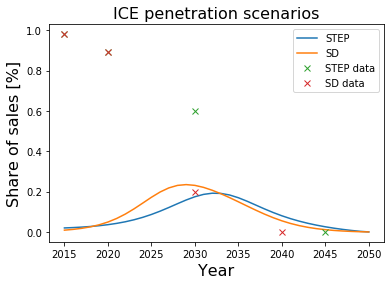

In [19]:
MyColorCycle = pylab.cm.Paired(np.arange(0,1,0.1)) # select 10 colors from the 'Paired' color map.
fig, ax = plt.subplots()
ax.plot(t[65:], dt_fit[0,1,65:], label='STEP')
ax.plot(t[65:], dt_fit[1,1,65:], label='SD')
ax.plot(df.loc[(df['Scenario']=='STEP') & (df['Drive_train']=='ICE'), 'Year'].values, df.loc[(df['Scenario']=='STEP') & (df['Drive_train']=='ICE'), 'Value'].values, 'x', label='STEP data')
ax.plot(df.loc[(df['Scenario']=='SD') & (df['Drive_train']=='ICE'), 'Year'].values, df.loc[(df['Scenario']=='SD') & (df['Drive_train']=='ICE'), 'Value'].values,'x',label='SD data')
ax.legend( loc='best',prop={'size':10})
ax.set_ylabel('Share of sales [%]',fontsize =16)
ax.set_title('ICE penetration scenarios'.format(s), fontsize=16)
ax.set_xlabel('Year',fontsize =16)

In [20]:
# Change the order of the drive trains to fit the model
drive_trains = np.zeros((NS, Ng, Nt))

drive_trains[:,0, :] = dt_fit[:,2,:] # ICEs
drive_trains[:,1, :] = dt_fit[:,0,:] # BEVs
drive_trains[:,2, :] = dt_fit[:,1,:] # Hybrids
drive_trains[:,3, :] = dt_fit[:,3,:] # Other (H+)

In [21]:
# define results path
results_path = os.path.join(os.getcwd(), 'data', 'scenario_data')
np.save(results_path+'/EV_penetration', drive_trains, allow_pickle=True)